In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

In [2]:
class DynSys:
    def __init__(self, param):
        self.param = param
        N_DATA, N_NODE, ALPHA = param['N_DATA'], param['N_NODE'], param['ALPHA']
        T, STD = param['T'], param['STD']

        ################################
        # Create Interaction matrix
        ################################
        self.M = np.zeros((N_NODE, N_NODE))
        for i in range(N_NODE):
            self.M[i, i] = ALPHA

        for i in range(N_NODE-1):
            self.M[i + 1, i] = 1 - ALPHA

        ################################
        # Create data
        ################################
        self.data = np.zeros((N_NODE, N_DATA))
        for i in range(1, N_DATA):
            self.data[:, i] = self.M.dot(self.data[:, i-1])        # Propagate signal
            self.data[0, i] += np.sin(2 * np.pi * i / T)           # Input to the first node
            self.data[:, i] += np.random.normal(0, STD, N_NODE)    # Noise to all nodes
           
        
    def computeTE(self, min_lag, max_lag):
        # a) Convert data to ITDxl format
        dataIDTxl = Data(self.data, dim_order='ps')

        # b) Initialise analysis object and define settings
        network_analysis = MultivariateTE()
        settings = {'cmi_estimator': 'JidtGaussianCMI',
                    'max_lag_sources': max_lag,
                    'min_lag_sources': min_lag}

        # c) Run analysis
        return network_analysis.analyse_network(settings=settings, data=dataIDTxl)

            
    def plot(self):    
        fig, ax = plt.subplots(ncols=2, figsize=(15,5))
        ax[0].imshow(self.M)
        ax[0].set_title("Connectivity-matrix")
        for j in range(self.param['N_NODE']):
            ax[1].plot(self.data[j], label=str(j))
        ax[1].legend()
        ax[1].set_title("Dynamics")
        plt.show()
        
def parseResults(results, N_NODE):
    out = {'src' : [], 'trg' : [], 'lag' : [], 'te' : [], 'p' : []}
    
    # Print details of TE estimation
    for i in range(N_NODE):
        rezThis = results.get_single_target(i, fdr=False)
        
        out['src'] += [val[0] for val in rezThis['selected_vars_sources']]
        out['lag'] += [val[1] for val in rezThis['selected_vars_sources']]
        out['te']  += list(rezThis['selected_sources_te'])
        out['p']   += list(rezThis['selected_sources_pval'])
        out['trg'] += [i] * len(rezThis['selected_sources_pval'])
    
    df = pd.DataFrame.from_dict(out)
    df = df.sort_values(by=['src', 'trg'])
    
    return df
    

In [3]:
# Set parameters
param = {
    'ALPHA'   : 0.9,
    'N_NODE'  : 5,
    'N_DATA'  : 10000,
    'T'       : 100,
    'STD'     : 0.2
}
min_lag, max_lag = 1, 5

# Create dynamical system and compute TE
DS1 = DynSys(param)
results = DS1.computeTE(min_lag, max_lag)

Adding data with properties: 5 processes, 10000 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (4, 

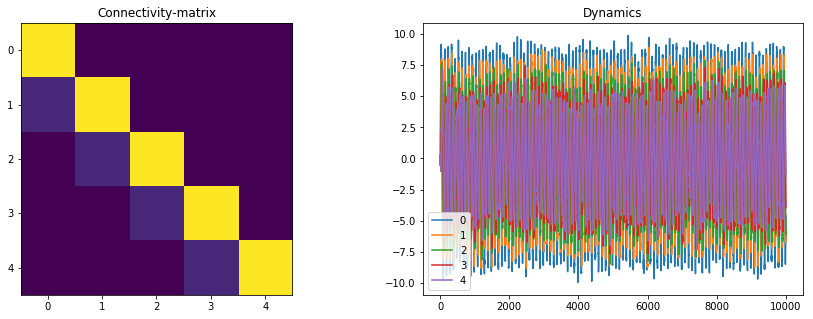

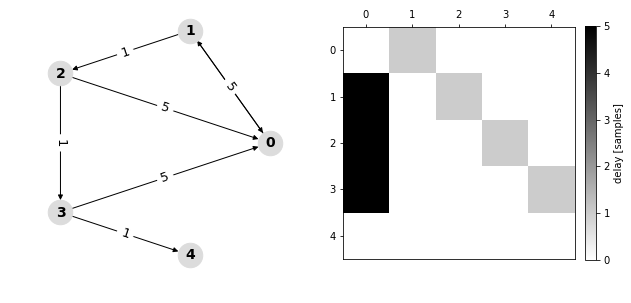

In [4]:
# Plot dynamical system
DS1.plot()

# Plot inferred network to console and via matplotlib
#results.print_edge_list(weights='max_te_lag', fdr=False)
plot_network(results=results, weights='max_te_lag', fdr=False)
plt.show()

# Print details of TE estimation
parsedRes = parseResults(results, param['N_NODE'])

### 2. STATISTICAL SANITY CHECK

**TODO:**
1. Construct sets: `[lags], [N_NODE], [noise variances], [period lengths]`
2. Subselect reasonable combinations
3. Run code for each
4. For each run, save: `MAT_TE, MAT_DELAY`
5. Compute:
  * Frequency number correct connection = N as function of N
  * Frequency all correct delays are correct
  * Frequency exists fake connect
  * Ratio MAX_FAKE_TE / AVG_REAL_TE, MAX_FAKE_TE / MIN_REAL_TE
  * Number of fake, number of fake within 10% of MAX_FAKE_TE
  * Effect of noise for fixed everything else, max_lag=1 and max_lag=6
  * Effect of period for fixed everything else, max_lag=1 and max_lag=6

In [7]:
%%time
# Set parameters
param = {
    'ALPHA'   : 0.9,
    'N_NODE'  : 5,
    'N_DATA'  : 10000,
    'T'       : 100,
    'STD'     : 0.2
}
min_lag, max_lag = 1, 5

nDataLst = (10**(np.linspace(2, 4, 10))).astype(int)
resultsLst = []

for N_DATA in nDataLst:
    param['N_DATA'] = N_DATA
    
    DS1 = DynSys(param)
    resultsLst += [parseResults(DS1.computeTE(min_lag, max_lag), param['N_NODE'])]

Adding data with properties: 5 processes, 100 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, 5)]
 -- significant

---------------

testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(0, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(1, 1), (1, 5), (0, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(0, 1)]
final target samples: [(1, 1), (1, 5)]



####### analysing target with index 2 from list [0, 1, 2, 3, 4]

Target: 2 - testing sources [0, 1, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(2, 1), (2, 2), (2, 3), (2, 4), (2, 5)]
testing candidate: (2, 1) 
maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 

testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maximum statistic, n_perm: 200
testing candidate: (4, 5) maximum statistic, n_perm: 200
testing candidate: (4, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0,

testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 5)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (1, 5)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 5)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Target: 1 - testing sources [0, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0,

testing candidate: (2, 5) maximum statistic, n_perm: 200
testing candidate: (2, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (1, 1) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(1, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(2, 1), (2, 5), (1, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(1, 1)]
final target samples: [(2, 1), (2, 5)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4]

Target: 3 - testing sources [0, 1, 2, 4]

---------------------------- (1)

 -- not significant

---------------------------- (2) include source candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (2, 1) maximum statistic, n_perm: 200
testing candidate: (2, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(3, 1), (3, 5), (2, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 1)]
final target samples: [(3, 1), (3, 5)]



####### analysing target with index 4 from list [0, 1, 2, 3, 4]

Target: 4 - testing sources [0, 1, 2, 3]

---------------------------- (1) include target candidates
candidate set: [(4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
testing candidate: (4, 1) 
maxi

testing candidate: (3, 1) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(3, 1)]
 -- significant

---------------------------- (4) final statistics
selected variables: [(4, 1), (4, 5), (3, 1)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(3, 1)]
final target samples: [(4, 1), (4, 5)]


Adding data with properties: 5 processes, 5994 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4]

Target: 0 - testing sources [1, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significan

testing candidate: (4, 4) maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(2, 5), (3, 5), (1, 4), (4, 4)]
testing candidate: (4, 4) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (0, 5), (2, 5), (3, 5), (1, 4), (4, 4)]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500
final source samples: [(2, 5), (3, 5), (1, 4), (4, 4)]
final target samples: [(0, 1), (0, 5)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4]

Target: 1 - testing sources [0, 2, 3, 4]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 1) 
maximum statistic, n_perm: 200
testing candidate: (1, 5) maximum statistic, n_perm: 200
testing candidate: (1, 3) maximum statistic

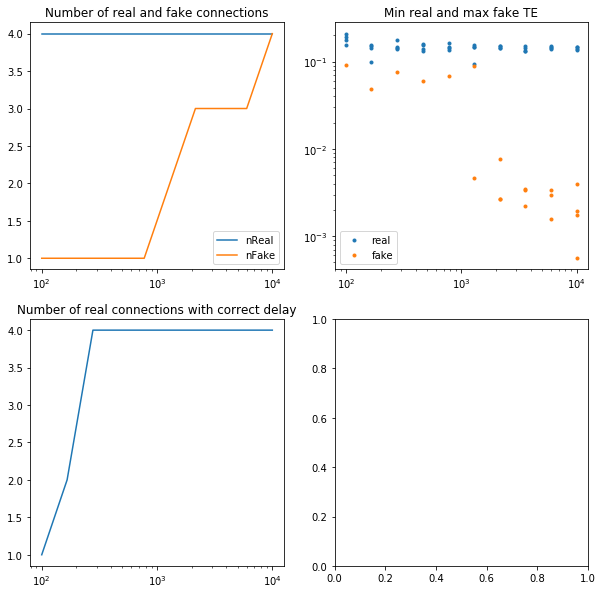

In [37]:
def flatten(lst):
    return [v for sublst in lst for v in sublst]

statsGlob = {'realTE' : [], 'fakeTE' : [], 'realLag' : [], 'fakeLag' : []}

for N_DATA, rez in zip(nDataLst, resultsLst):
    statsLoc = {'realTE' : [], 'fakeTE' : [], 'realLag' : [], 'fakeLag' : []}
    
    for index, row in rez.iterrows():
        i, j = int(row['src']), int(row['trg'])
        if DS1.M[j,i] == 0:
            statsLoc['fakeTE'] += [row['te']]
            statsLoc['fakeLag'] += [row['lag']]
        else:
            statsLoc['realTE'] += [row['te']]
            statsLoc['realLag'] += [row['lag']]
        
    for key, val in statsLoc.items():
        statsGlob[key] += [val]

    
######################
# Analysis
######################
nReal = [len(l) for l in statsGlob['realTE']]  # Number of real connections
nFake = [len(l) for l in statsGlob['fakeTE']]  # Number of fake connections

nDataLstReal = [[i]*n for i,n in zip(nDataLst, nReal)]  # Amount of data used to calculate each real TE
nDataLstFake = [[i]*n for i,n in zip(nDataLst, nFake)]  # Amount of data used to calculate each fake TE

nRealGoodDelay = [np.count_nonzero(np.array(lagLst) == 1) for lagLst in statsGlob['realLag']]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax[0][0].semilogx(nDataLst, nReal, label='nReal')
ax[0][0].semilogx(nDataLst, nFake, label='nFake')
ax[0][0].legend()
ax[0][0].set_title('Number of real and fake connections')

ax[0][1].loglog(flatten(nDataLstReal), flatten(statsGlob['realTE']), '.', label='real')
ax[0][1].loglog(flatten(nDataLstFake), flatten(statsGlob['fakeTE']), '.', label='fake')
ax[0][1].legend()
ax[0][1].set_title('Min real and max fake TE')

ax[1][0].semilogx(nDataLst, nRealGoodDelay)
ax[1][0].set_title('Number of real connections with correct delay')
plt.show()